In [38]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import seaborn as sns


In [2]:
_data_dir = os.path.join('.', 'data')
_train_filename = os.path.join(_data_dir, 'ne_play_predictions_train.csv')
_eval_filename = os.path.join(_data_dir, 'ne_play_predictions_eval.csv')
_predict_filename = os.path.join(_data_dir, 'ne_play_predictions_holdout.csv')

In [3]:
def load_prediction_data(filename):
    column_dtypes = {
        'gsis_id': np.int32,
        'drive_id': np.int32,
        'play_id': np.int32,
        'home_score': np.int32,
        'away_score': np.int32,
        'yardline': np.int32,
        'quarter': np.int32,
        'clock': np.int32,
        'down': np.int32,
        'yards_to_go': np.int32
    }
    df = pd.read_csv(filename)
    
    # Change identity categoricals to 0-based
    df.quarter = df.quarter - 1
    df.down = df.down - 1
    df = df.loc[df.pos_team == 'NE']
    df = df.reset_index()
    
    return df

In [4]:
train_data = load_prediction_data(_train_filename)
train_labels = train_data.pop('play_type')

eval_data = load_prediction_data(_eval_filename)
eval_labels = eval_data.pop('play_type')

train_data.head()

,index,gsis_id,drive_id,play_id,home_team,away_team,home_score,away_score,quarter,clock,down,yards_to_go,yardline,pos_team,point_differential
0,0,2014092105,11,2465,NE,OAK,10,6,2,376,1,10,-20,NE,4
1,1,2009092705,12,2913,NE,ATL,16,10,2,894,1,10,34,NE,6
2,3,2012122304,22,3713,JAC,NE,16,23,3,427,2,5,-25,NE,7
3,6,2012121613,24,3753,NE,SF,17,31,3,131,2,2,-8,NE,-14
4,7,2010091911,10,2215,NYJ,NE,10,14,2,200,2,3,-1,NE,4


In [5]:
train_data.size

51870

In [6]:
unique_labels = ['rush', 'pass', 'punt', 'field goal']

In [7]:
train_input_fn = tf.estimator.inputs.pandas_input_fn(x=train_data, y=train_labels, shuffle=True, batch_size=32, num_epochs=None)
eval_input_fn = tf.estimator.inputs.pandas_input_fn(x=eval_data, y=eval_labels, shuffle=False, num_epochs=1)

In [10]:
tf.feature_column.numeric_column('yardline')
yards_to_go = tf.feature_column.numeric_column('yards_to_go')
yards_to_go_bucketized = tf.feature_column.bucketized_column(yards_to_go, boundaries=[1,2,3,5,8,10,15,20])
yardline = tf.feature_column.numeric_column('yardline')
yardline_bucketized = tf.feature_column.bucketized_column(yardline, boundaries=[-50,-45,-40,-30,-20,-10,0,10,20,30,40,45,48])
quarter = tf.feature_column.categorical_column_with_identity('quarter', num_buckets=4)
down = tf.feature_column.categorical_column_with_identity('down', num_buckets=4)
point_differential = tf.feature_column.numeric_column('point_differential')
point_differential_bucketized = tf.feature_column.bucketized_column(point_differential, boundaries=[-21, -17, -14, -10, -7, -3, -2, -1, 0, 1, 2, 3, 7, 10, 14, 17, 21])
clock = tf.feature_column.numeric_column('clock')
clock_bucketized = tf.feature_column.bucketized_column(clock, boundaries=[120, 480, 700, 820])

numeric_features = [
    tf.feature_column.numeric_column('home_score'),
    tf.feature_column.numeric_column('away_score'),
    point_differential
]

categorical_features = [
    quarter,
    down
]

crossed_columns = [
    tf.feature_column.embedding_column(tf.feature_column.crossed_column([down, yards_to_go_bucketized], hash_bucket_size=1000), 1),
    tf.feature_column.embedding_column(tf.feature_column.crossed_column([quarter, down, clock_bucketized, yards_to_go_bucketized], hash_bucket_size=1000), 4),
    tf.feature_column.embedding_column(tf.feature_column.crossed_column([point_differential_bucketized, clock_bucketized], hash_bucket_size=1000), 1),
    tf.feature_column.embedding_column(
        tf.feature_column.crossed_column([point_differential_bucketized, yards_to_go_bucketized, yardline_bucketized, quarter, down, clock_bucketized], hash_bucket_size=50000), 20)
]

features = numeric_features + crossed_columns

In [11]:
estimator = tf.estimator.DNNClassifier(feature_columns=features,
                                       hidden_units=[10,10],
                                       n_classes=4,
                                       dropout=0.1,
                                       label_vocabulary=unique_labels,
                                       model_dir='./model')

estimator.train(train_input_fn, steps=100)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000028AF200DF28>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model\model.ckpt-1040000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1040001 into ./model\model.

In [12]:
estimator.evaluate(eval_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-03-21:48:34
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model\model.ckpt-1040100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-03-21:48:34
INFO:tensorflow:Saving dict for global step 1040100: accuracy = 0.5755814, average_loss = 17.528652, global_step = 1040100, loss = 2153.52


{'accuracy': 0.5755814,
 'average_loss': 17.528652,
 'loss': 2153.52,
 'global_step': 1040100}

In [13]:
predict_data = load_prediction_data(_predict_filename)
predict_labels = predict_data.pop('play_type')

predict_input_fn = tf.estimator.inputs.pandas_input_fn(predict_data, predict_labels, shuffle=False, num_epochs=1)

predictions = [row['classes'] for row in list(estimator.predict(predict_input_fn))]
predictions = pd.DataFrame(predictions, columns=['prediction'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model\model.ckpt-1040100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [14]:
joined = predictions.join(predict_labels).join(predict_data)

# Make Quarter and Down look normal again for output
joined.quarter = joined.quarter + 1
joined.down = joined.down + 1
joined.prediction = joined.prediction.apply(lambda x: str(x, 'utf-8'))
joined.head()

,prediction,play_type,index,gsis_id,drive_id,play_id,home_team,away_team,home_score,away_score,quarter,clock,down,yards_to_go,yardline,pos_team,point_differential
0,punt,punt,1,2012092313,20,4501,BAL,NE,28,30,4,779,4,16,-1,NE,2
1,rush,rush,8,2012111103,11,2357,NE,BUF,24,17,3,110,1,10,-1,NE,7
2,punt,punt,9,2014101201,10,1900,BUF,NE,7,7,2,752,4,7,-27,NE,0
3,punt,field goal,11,2015092001,21,4097,BUF,NE,13,37,3,867,4,10,18,NE,24
4,pass,pass,12,2013121504,17,3464,MIA,NE,17,19,4,646,2,10,26,NE,2


In [15]:
fourth_and_short = joined.loc[(joined.down == 4) & (joined.yards_to_go == 1)]

In [16]:
fourth_and_short.loc[fourth_and_short.prediction == fourth_and_short.play_type].size

68

In [17]:
fourth_and_short.loc[(fourth_and_short.prediction != fourth_and_short.play_type) & (fourth_and_short.play_type == 'punt')]

fourth_and_short.loc[(fourth_and_short.prediction.isin(['rush', 'pass'])) & (fourth_and_short.play_type.isin(['rush', 'pass']))].size

102

In [18]:
fourth_and_short

,prediction,play_type,index,gsis_id,drive_id,play_id,home_team,away_team,home_score,away_score,quarter,clock,down,yards_to_go,yardline,pos_team,point_differential
295,pass,punt,598,2013091200,15,2229,NE,NYJ,13,3,2,768,4,1,-12,NE,10
307,pass,rush,628,2013120802,17,3095,NE,CLE,0,12,3,689,4,1,-2,NE,-12
365,pass,field goal,747,2014101600,11,2795,NE,NYJ,20,19,3,645,4,1,32,NE,1
381,punt,punt,783,2009120613,5,1223,MIA,NE,7,14,2,374,4,1,-6,NE,7
537,pass,pass,1043,2012121613,30,4747,NE,SF,31,38,4,756,4,1,-38,NE,-7
648,punt,pass,1259,2015092001,12,1830,BUF,NE,7,21,2,495,4,1,-2,NE,14
674,rush,punt,1311,2011120413,14,3408,NE,IND,31,10,4,356,4,1,-21,NE,21
721,pass,pass,1410,2009092705,18,3871,NE,ATL,26,10,4,780,4,1,17,NE,16
728,pass,punt,1424,2011110609,2,260,NE,NYG,0,0,1,240,4,1,-18,NE,0
764,pass,rush,1495,2010120600,18,3189,NE,NYJ,38,3,4,250,4,1,31,NE,35


In [28]:
first_down = joined.loc[joined.down == 1]
second_down = joined.loc[joined.down == 2]
third_down = joined.loc[joined.down == 3]
first_down.size

7922

In [22]:
first_down.loc[first_down.prediction == first_down.play_type].size

4301

In [23]:
first_down.loc[first_down.prediction != first_down.play_type].size

3621

In [25]:
second_down.loc[second_down.prediction == second_down.play_type].size

3332

In [26]:
second_down.loc[second_down.prediction != second_down.play_type].size

2533

In [30]:
third_down.loc[third_down.prediction == third_down.play_type].size

2057

In [31]:
third_down.loc[third_down.prediction != third_down.play_type].size

969

In [32]:
third_and_short = third_down.loc[third_down.yards_to_go <= 3]

In [35]:
third_and_short.loc[third_and_short.prediction == third_and_short.play_type].size

680

In [36]:
third_and_short.loc[third_and_short.prediction != third_and_short.play_type].size

442

In [37]:
third_down.corr('pearson')

,index,gsis_id,drive_id,play_id,home_score,away_score,quarter,clock,down,yards_to_go,yardline,point_differential
index,1.000000,-0.022133,-0.012277,0.016543,0.012268,0.007848,0.006399,0.023016,NaN,-0.061573,-0.032181,-0.049789
gsis_id,-0.022133,1.000000,0.091253,0.127012,0.094487,-0.014417,0.148493,-0.006372,NaN,0.091112,0.031281,0.000899
drive_id,-0.012277,0.091253,1.000000,0.958138,0.649587,0.698745,0.911212,0.221406,NaN,0.094541,0.026118,0.413168
play_id,0.016543,0.127012,0.958138,1.000000,0.692301,0.701864,0.955955,0.243738,NaN,0.105595,0.057288,0.441675
home_score,0.012268,0.094487,0.649587,0.692301,1.000000,0.311107,0.693512,0.117798,NaN,-0.001173,0.145622,0.449233
away_score,0.007848,-0.014417,0.698745,0.701864,0.311107,1.000000,0.636591,0.183573,NaN,0.021066,-0.013102,0.252462
quarter,0.006399,0.148493,0.911212,0.955955,0.693512,0.636591,1.000000,0.025669,NaN,0.076638,0.044351,0.424948
clock,0.023016,-0.006372,0.221406,0.243738,0.117798,0.183573,0.025669,1.000000,NaN,0.075879,0.108271,0.017730
down,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yards_to_go,-0.061573,0.091112,0.094541,0.105595,-0.001173,0.021066,0.076638,0.075879,NaN,1.000000,-0.218209,-0.015057


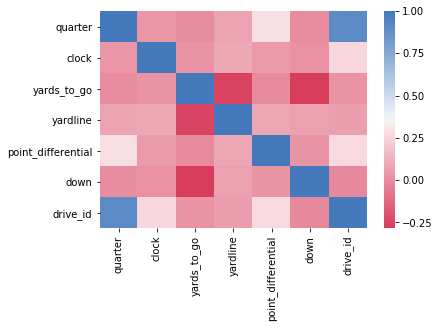

In [43]:
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
corr = joined.loc[:, ['quarter', 'clock', 'yards_to_go', 'yardline', 'point_differential', 'down', 'drive_id']].corr('pearson')
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap=cmap)